# Plot NWCSAF CT data as Matrix

This is a copy of the notebook [02-NWCSAF-CT-plot.ipynb](02-NWCSAF-CT-plot.ipynb). The filelist was updated to plot CT as function of resolution.

## Libs

In [1]:
%matplotlib inline

import os, sys, glob, copy
import numpy as np
import pylab as pl
import datetime
import scipy.ndimage
import pandas as pd
import xarray as xr
import seaborn as sns

pl.rcParams['figure.figsize'] = (16.0, 12.0)
pl.rcParams['font.size'] = 16.0


import nawdex_analysis.io.input_lev2 as input_lev2
import nawdex_analysis.io.selector

import nawdex_analysis.plot.nawdex_map
reload( nawdex_analysis.plot.nawdex_map )

<module 'nawdex_analysis.plot.nawdex_map' from '/vols/fs1/store/senf/.conda/python27mod/lib/python2.7/site-packages/nawdex_analysis/plot/nawdex_map.pyc'>

## A subsampling funciton for speed

In [2]:
def subsamp2d( d, nsub = 4 ):
    
    dsub = {}
    for k in d.keys():
        
        v = d[k]

        try:
            if np.ndim(v) == 2:
                vsub = v[::nsub, ::nsub]
        except:
            vsub = v
            print '%s not an 2d array?' % k
            
        dsub[k] = vsub
        
    return dsub
        

## Plot of NWCSAF CT

### Input Data

In [5]:
time = datetime.datetime(2016,9,23, 12, 0)

In [6]:
flist = nawdex_analysis.io.selector.make_filetime_index('CT', time, subdirs=['meteosat', 'synsat'])


In [7]:
flist[time]

['/vols/fs1/store/senf/data/icon/nawdex//meteosat/nwcsaf_msevi-nawdex-20160923.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-80km-mis-0002.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-10km-mis-0001.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-2km-mis-0002-shcon_0034.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-80km-mis-0003.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-5km-mis-0001.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-80km-mis-0001.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-20km-mis-0002.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-2km-mis-0001-shcon.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-40km-mis-0002.nc',
 '/vols/fs1/store/senf/data/icon/nawdex//synsat/nwcsaf_synsat-nawdexnwp-5km-mis-000

In [8]:
dstack = {}

for fname in flist[time]:
    if 'mis-0001' in fname or 'msevi' in fname:

        basename = os.path.basename( fname )
        dstack[basename] = input_lev2.read_data_field( fname, time, 'CT')


.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5
.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5


In [9]:
sorted_fnames = np.array(sorted( dstack ))
sorted_fnames

array(['nwcsaf_msevi-nawdex-20160923.nc',
       'nwcsaf_synsat-nawdexnwp-10km-mis-0001.nc',
       'nwcsaf_synsat-nawdexnwp-20km-mis-0001.nc',
       'nwcsaf_synsat-nawdexnwp-2km-mis-0001-shcon.nc',
       'nwcsaf_synsat-nawdexnwp-2km-mis-0001-shcon_0034.nc',
       'nwcsaf_synsat-nawdexnwp-2km-mis-0001.nc',
       'nwcsaf_synsat-nawdexnwp-40km-mis-0001.nc',
       'nwcsaf_synsat-nawdexnwp-5km-mis-0001.nc',
       'nwcsaf_synsat-nawdexnwp-80km-mis-0001.nc'], dtype='|S50')

### Sort Names differently

In [10]:
sorted_fnames = np.array(
        ['nwcsaf_msevi-nawdex-20160923.nc',       
         'nwcsaf_synsat-nawdexnwp-2km-mis-0001.nc',
         'nwcsaf_synsat-nawdexnwp-5km-mis-0001.nc',
         'nwcsaf_synsat-nawdexnwp-10km-mis-0001.nc',
         'nwcsaf_synsat-nawdexnwp-20km-mis-0001.nc',
         'nwcsaf_synsat-nawdexnwp-40km-mis-0001.nc',
         'nwcsaf_synsat-nawdexnwp-80km-mis-0001.nc'], )

### Region Masking

In [11]:
m = input_lev2.read_mask(region='atlantic')['mask']

.. open  /vols/fs1/store/senf/data/icon/nawdex//region_masks_for_msevi_nawdex.h5


In [12]:
for fname in sorted_fnames:
    dstack[fname]['CT'] = np.ma.masked_where( ~m, dstack[fname]['CT'])

### Subsampling

In [13]:
if False:
    for fname in sorted_fnames:
        dstack[fname] = subsamp2d( dstack[fname], nsub = 8 )
    

## Solve Issues with NaN Georef Values

`pcolormesh` does not allow for NaNs in the georef. NaNs will be replaced by an arbitrary value.

In [19]:
def denan_georef( d ):
    d['lon'][np.isnan( d['lon'] )] = 1e23
    d['lat'][np.isnan( d['lat'] )] = 1e23

In [20]:
for fname in sorted_fnames:
    denan_georef( dstack[fname] )

## Colormapping

We like to plot only a subset of cloud type which are selected by index.

In [21]:
def ct_colormapping( cindex ):
    
    
    # default color list provided by NWCSAF
    colorlist = ['#007800', '#000000','#fabefa','#dca0dc',
                 '#ff6400', '#ff6400', '#ffb400', '#ffb400',
                 '#f0f000', '#f0f000','#d7d796','#d7d796',
                 '#e6e6e6', '#e6e6e6', '#0050d7', '#00b4e6',
                 '#00f0f0', '#5ac8a0', '#c800c8']
    
    if cindex is None:
        return colorlist
    else:    
        color_selected = np.array( colorlist )[np.array(cindex) - 1]
    
        return color_selected

### CT field mapping

In [22]:

def ct_mapping( ct, cindex, ntypes = 20 ):
    
    if cindex is None:
        return ct
    
    # init mapping index
    mapping_index = np.zeros( ntypes ).astype( np.int ) 
    
    # overwrite mapping index with cloud types
    n = 1
    for cind in cindex:
        
        mapping_index[cind] = n
        n += 1
        
    # do the mapping
    ct_mapped = mapping_index[ ct.data.astype(np.int) ]
    
    ct_mapped = np.ma.masked_where( ct.mask, ct_mapped)
    
    return ct_mapped
    



### NAWDEX Plot Routine

In [23]:
## from nawdex_analysis.plot.nawdex_map.nawdex_nwcsaf_plot??
from nawdex_analysis.plot.nawdex_map import nwcsaf_product_colorbar, nawdex_map

def nawdex_nwcsaf_plot(dset, vname = 'CMa',region = 'zenith75', cindex = None, plot_colorbar = True):
        
        

    mp = nawdex_map( region = region, color = 'gold' )
    
    # map geo-ref 
    x, y = mp(dset['lon'], dset['lat'])
    m  = dset['mask']

    vm = np.ma.masked_where( ~m, dset[vname] )

    cmap = pl.cm.get_cmap('bone', 4)

    if vname == 'CMa':
        pcm = mp.pcolormesh(x, y, vm, cmap = cmap, vmin = 1, vmax = 5)


    if vname == 'CT':
        

        colorlist = ct_colormapping( cindex )
        print colorlist, len(colorlist)
        cmap = pl.matplotlib.colors.ListedColormap( colorlist )
        vmapped = ct_mapping( vm, cindex )

        pcm = mp.pcolormesh(x,y, vmapped, cmap = cmap, vmin = 1, vmax = len( colorlist ) + 1)


    if plot_colorbar:
        nwcsaf_product_colorbar( pcm, vname = vname )

    return mp

## Plotting 

['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9
['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9
['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9
['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9
['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9
['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9
['#000000' '#ff6400' '#ffb400' '#f0f000' '#d7d796' '#e6e6e6' '#0050d7'
 '#00b4e6' '#00f0f0'] 9


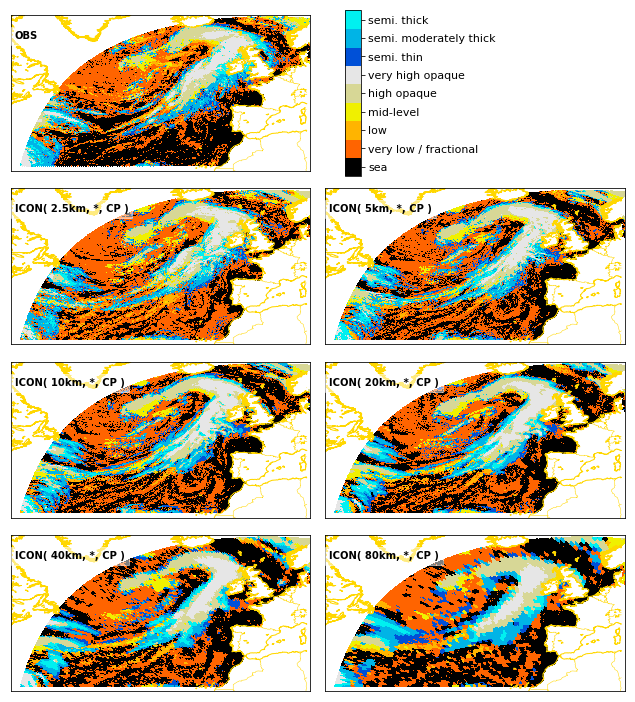

In [24]:
fig, axs = pl.subplots( nrows = 4, ncols = 2, figsize = (11, 14), sharex = True, sharey = True )
axs = axs.flatten()


labs = ['OBS', 
        'ICON( 2.5km, *, CP )', 'ICON( 5km, *, CP )', 
        'ICON( 10km, *, CP )',  'ICON( 20km, *, CP )',
        'ICON( 40km, *, CP )',  'ICON( 80km, *, CP )']



for i, basename in enumerate( sorted_fnames ):
        
    if i > 0:
        j = i + 1
    else:
        j = i
    a = axs[j]
    pl.sca( a )
    
    d = dstack[basename]
    
    # add fracitonal to very low
    d['CT'][d['CT'] == 19] = 6
    
    mp = nawdex_nwcsaf_plot(d, vname = 'CT', cindex = [2, 6, 8, 10, 12,14, 15, 16, 17,],
                                                            region = 'atlantic', 
                                                            plot_colorbar = False )
    
    a.text(-64, 60, labs[i], va = 'bottom', ha = 'left', fontweight = 'bold' , 
                          bbox = dict(facecolor='white', edgecolor = 'white', alpha=0.5))
    
    if i == 1:
        a = axs[i]
        a.axis('off')
        #a.clear()
        apos = a.get_position()
        cax = fig.add_axes( [apos.x0, apos.y0, 0.02, apos.height] )

        #        pl.sca( a )
#        pl.cla( )
        pcm = axs[0].collections[-1]

        cbar = pl.colorbar( pcm,  cax, ticks= np.arange(9) + 1.5,)
        
        cbar.ax.set_yticklabels(['sea',  
                                 'very low / fractional', 'low', 'mid-level', 'high opaque', 'very high opaque', 
                                 'semi. thin', 'semi. moderately thick', 'semi. thick', 
                             ], fontsize = 11)

    
#    if i >= 1:
#        break
    
    
    xlim, ylim = ((-65, 10.802031483325052), (27.0, 66.5))
    a.set_xlim( xlim )
    a.set_ylim( ylim )

pl.subplots_adjust( hspace = 0.05, wspace = 0.05, bottom = 0.2)


pl.savefig('../pics/CT-overview-resolution.png')